In [2]:
# !ls -lh

In [4]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
id = '1i9w3cwUKBzUS9KwRCq6POlnHn2LZF4Aw'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('06.csv')
id = '1xi8xwjfqFujGg_DXab2MrgK5n2CZoFLu'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('07.csv')
id = '1YsQtntyk2seWNIqOis96AZrSA1EGiyQ5'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('08.csv')

In [6]:
import pandas as pd
import numpy as np
import glob
import pickle
%pylab inline
import seaborn as sns
import time
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

Populating the interactive namespace from numpy and matplotlib


In [7]:
#load dataset
df = pd.concat([
    pd.read_csv(x, nrows=500000, 
                usecols=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance',
                       'PULocationID', 'DOLocationID', 'fare_amount', 'extra', 'mta_tax',
                       'tip_amount', 'tolls_amount', 'total_amount',
                       'duration', 'avg_speed'],
                dtype= {'PULocationID': 'category', 'DOLocationID': 'category',
                        'trip_distance': np.float16,
                       'extra': np.float16, 'tip_amount': np.float16,
                       'tolls_amount': np.float16, 'total_amount': np.float16,
                       'duration': np.float16, 'avg_speed': np.float16})
    for x in glob.glob('0*.csv')])

In [8]:
#define a data preprocessing function
def data_preprocessing(df):
  # df['mta_tax'] = (df['mta_tax'] * 2).astype(np.int8)
  # df['PULocationID_fare_amount'] = df['PULocationID'].map(df.groupby(['PULocationID'])['fare_amount'].mean())
  # df['DOLocationID_fare_amount'] = df['DOLocationID'].map(df.groupby(['DOLocationID'])['fare_amount'].mean())
  # df['trip_distance_div_tip_amount'] = df['trip_distance'] / (df['tip_amount'] + 0.01)
  # df['trip_distance_div_total_amount'] = df['trip_distance'] / (df['total_amount'] + 0.01)
  df['trip_distance_div_duration'] = df['trip_distance'] / (df['duration'] + 0.01)
  # df['trip_distance_div_duration'] = df['trip_distance'] / (df['duration'] + 0.01)

  # df['tip_amount_add_tolls_amount'] = df['tip_amount'] + df['tolls_amount']
  # df['tip_amount_add_tolls_amount_add_total_amount'] = df['tip_amount'] + df['tolls_amount'] + df['total_amount']

  df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
  df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

  df['tpep_pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
  df['tpep_dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour

  df['PULocationID'] = df['PULocationID'].astype(int) 
  df['DOLocationID'] = df['DOLocationID'].astype(int) 
  df=df.drop(['PULocationID','DOLocationID','fare_amount','extra','mta_tax','tip_amount','tolls_amount','avg_speed'],axis=1)
  return df

In [9]:
df=data_preprocessing(df)

In [10]:
#check memory usage of dataset
df.memory_usage()

Index                         12000000
tpep_pickup_datetime          12000000
tpep_dropoff_datetime         12000000
trip_distance                  3000000
total_amount                   3000000
duration                       3000000
trip_distance_div_duration     3000000
tpep_pickup_hour              12000000
tpep_dropoff_hour             12000000
dtype: int64

In [11]:
#check whether dataset contain null value 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500000 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   tpep_pickup_datetime        1500000 non-null  datetime64[ns]
 1   tpep_dropoff_datetime       1500000 non-null  datetime64[ns]
 2   trip_distance               1500000 non-null  float16       
 3   total_amount                1500000 non-null  float16       
 4   duration                    1500000 non-null  float16       
 5   trip_distance_div_duration  1500000 non-null  float16       
 6   tpep_pickup_hour            1500000 non-null  int64         
 7   tpep_dropoff_hour           1500000 non-null  int64         
dtypes: datetime64[ns](2), float16(4), int64(2)
memory usage: 68.7 MB


In [12]:
#check types of each feature
df.dtypes

tpep_pickup_datetime          datetime64[ns]
tpep_dropoff_datetime         datetime64[ns]
trip_distance                        float16
total_amount                         float16
duration                             float16
trip_distance_div_duration           float16
tpep_pickup_hour                       int64
tpep_dropoff_hour                      int64
dtype: object

In [13]:
df = df.sample(frac=1.0)

In [14]:
idx = 50000
X_train=df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'total_amount'], axis=1).iloc[:-idx]
Y_train=df['total_amount'].iloc[:-idx]
X_test=df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'total_amount'], axis=1).iloc[:-idx]
Y_test=df['total_amount'].iloc[:-idx]

In [15]:
#Pre-train tests to ensure correct implementation
def test_lr_output_shape(X_train,Y_train,X_test,Y_test):
    model = LinearRegression(fit_intercept=True, normalize=True)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    assert pred_train.shape == (Y_train.shape[0],), 'model output should be same as training labels.'
    assert pred_test.shape == (Y_test.shape[0],), 'model output should be same as testing labels.'
    print("Linear regression model prediction shape test success!")

def test_ridge_output_shape(X_train,Y_train,X_test,Y_test):
    model = Ridge(alpha=0.2,fit_intercept=True,max_iter=500,normalize=False)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    assert pred_train.shape == (Y_train.shape[0],), 'model output should be same as training labels.'
    assert pred_test.shape == (Y_test.shape[0],), 'model output should be same as testing labels.'
    print("Ridge regression model prediction shape test success!")

def test_MLP_output_shape(X_train,Y_train,X_test,Y_test):
    model = MLPRegressor(hidden_layer_sizes=30,learning_rate_init=0.01,max_iter=5,early_stopping=True,verbose=True)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    assert pred_train.shape == (Y_train.shape[0],), 'model output should be same as training labels.'
    assert pred_test.shape == (Y_test.shape[0],), 'model output should be same as testing labels.'
    print("Multilayer Perceptron model prediction shape test success!")

In [16]:
test_lr_output_shape(X_train,Y_train,X_test,Y_test)
print("----------------------------------------------------------------------------")
test_ridge_output_shape(X_train,Y_train,X_test,Y_test)
print("----------------------------------------------------------------------------")
test_MLP_output_shape(X_train,Y_train,X_test,Y_test)

Linear regression model prediction shape test success!
----------------------------------------------------------------------------
Ridge regression model prediction shape test success!
----------------------------------------------------------------------------
Iteration 1, loss = 6.27344451
Validation score: 0.931713
Iteration 2, loss = 5.88257622
Validation score: 0.931990
Iteration 3, loss = 5.68246746
Validation score: 0.933411
Iteration 4, loss = 5.46486129
Validation score: 0.936453
Iteration 5, loss = 5.41435579
Validation score: 0.932690


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Multilayer Perceptron model prediction shape test success!


In [17]:
def test_lr_output_range(X_train,Y_train,X_test,Y_test):
    model = LinearRegression(fit_intercept=True, normalize=True)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    assert (pred_train >= 0).all() & (pred_test >= 0).all(), 'model output should range from 0 to 1 inclusive'
    print("Linear regression model output range test success!")

def test_Ridge_output_range(X_train,Y_train,X_test,Y_test):
    model = Ridge(alpha=0.2,fit_intercept=True,max_iter=500,normalize=False)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    assert (pred_train >= 0).all() & (pred_test >= 0).all(), 'model output should range from 0 to 1 inclusive'
    print("Ridge regression model output range test success!")

def test_MLP_output_range(X_train,Y_train,X_test,Y_test):
    model = MLPRegressor(hidden_layer_sizes=30,learning_rate_init=0.01,max_iter=5,early_stopping=True,verbose=True)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    assert (pred_train >= 0).all() & (pred_test >= 0).all(), 'model output should range from 0 to 1 inclusive'
    print("Multilayer Perceptron model output range test success!")

In [18]:
test_lr_output_range(X_train,Y_train,X_test,Y_test)
print("----------------------------------------------------------------------------")
test_Ridge_output_range(X_train,Y_train,X_test,Y_test)
print("----------------------------------------------------------------------------")
test_MLP_output_range(X_train,Y_train,X_test,Y_test)

Linear regression model output range test success!
----------------------------------------------------------------------------
Ridge regression model output range test success!
----------------------------------------------------------------------------
Iteration 1, loss = 6.21668372
Validation score: 0.931223
Iteration 2, loss = 5.60657490
Validation score: 0.938719
Iteration 3, loss = 5.49421291
Validation score: 0.939158
Iteration 4, loss = 5.46465460
Validation score: 0.939489
Iteration 5, loss = 5.46738058
Validation score: 0.939431


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Multilayer Perceptron model output range test success!


variance

In [19]:
def test_lr_variance(X_train,Y_train,X_test,Y_test):
    model = LinearRegression(fit_intercept=True, normalize=True)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    assert (explained_variance_score(Y_test, pred_test)>0.9), 'model variance_score should > 0.9'
    print("Linear regression model variance>0.9 success")


def test_Ridge_variance(X_train,Y_train,X_test,Y_test):
    model = Ridge(alpha=0.2,fit_intercept=True,max_iter=500,normalize=False)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    assert (explained_variance_score(Y_test, pred_test)>0.9), 'model variance_score should > 0.9'
    print("Ridge regression model variance>0.9 success")


def test_MLP_variance(X_train,Y_train,X_test,Y_test):
    model = MLPRegressor(hidden_layer_sizes=30,learning_rate_init=0.01,max_iter=5,early_stopping=True,verbose=True)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    assert (explained_variance_score(Y_test, pred_test)>0.9), 'model variance_score should > 0.9'
    print("Multilayer Perceptron model variance>0.9 success")



In [20]:
test_lr_variance(X_train,Y_train,X_test,Y_test)
print("----------------------------------------------------------------------------")
test_Ridge_variance(X_train,Y_train,X_test,Y_test)
print("----------------------------------------------------------------------------")
test_MLP_variance(X_train,Y_train,X_test,Y_test)

Linear regression model variance>0.9 success
----------------------------------------------------------------------------
Ridge regression model variance>0.9 success
----------------------------------------------------------------------------
Iteration 1, loss = 6.42991098
Validation score: 0.936592
Iteration 2, loss = 5.52992850
Validation score: 0.934085
Iteration 3, loss = 5.48456568
Validation score: 0.938976
Iteration 4, loss = 5.47101105
Validation score: 0.939389
Iteration 5, loss = 5.44886302
Validation score: 0.937634


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Multilayer Perceptron model variance>0.9 success


Max error

In [21]:
def test_lr_maxerror(X_train,Y_train,X_test,Y_test):
    model = LinearRegression(fit_intercept=True, normalize=True)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

  #  assert (max_error(Y_train, pred_train)==0), 'max_error in training set should be 0'
   # print("max error test in training set success!")
    print( print(max_error(Y_train, pred_train)))


def test_Ridge_maxerror(X_train,Y_train,X_test,Y_test):
    model = Ridge(alpha=0.2,fit_intercept=True,max_iter=500,normalize=False)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    #assert (max_error(Y_train, pred_train)==0), 'max_error in training set should be 0'
   # print("max error test in training set success!")
    print(max_error(Y_train, pred_train))


def test_MLP_maxerror(X_train,Y_train,X_test,Y_test):
    model = MLPRegressor(hidden_layer_sizes=30,learning_rate_init=0.01,max_iter=5,early_stopping=True,verbose=True)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
   # assert (max_error(Y_train, pred_train)==0), 'max_error in training set should be 0'
   # print("max error test in training set success!")
    print(max_error(Y_train, pred_train))

In [22]:
test_lr_maxerror(X_train,Y_train,X_test,Y_test)
print("----------------------------------------------------------------------------")
test_Ridge_maxerror(X_train,Y_train,X_test,Y_test)
print("----------------------------------------------------------------------------")
test_MLP_maxerror(X_train,Y_train,X_test,Y_test)

218.32766470474357
None
----------------------------------------------------------------------------
218.32766858407354
----------------------------------------------------------------------------
Iteration 1, loss = 6.26161645
Validation score: 0.923417
Iteration 2, loss = 5.53682498
Validation score: 0.938614
Iteration 3, loss = 5.49859236
Validation score: 0.939994
Iteration 4, loss = 5.47956893
Validation score: 0.940108
Iteration 5, loss = 5.45521653
Validation score: 0.939110


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


218.32164741365057


MAE

In [26]:
def test_lr_RMSE(X_train,Y_train,X_test,Y_test):
    model = LinearRegression(fit_intercept=True, normalize=True)
    model.fit(X_train,Y_train)

    pred_test = model.predict(X_test)

    assert (np.sqrt(mean_squared_error(pred_test,Y_test))<5)
    print("Linear regression model RMSE < 5 success")


def test_Ridge_RMSE(X_train,Y_train,X_test,Y_test):
    model = Ridge(alpha=0.2,fit_intercept=True,max_iter=500,normalize=False)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    assert (np.sqrt(mean_squared_error(Y_test, pred_test))<5)
    print("Ridge regression model RMSE < 5 success")


def test_MLP_RMSE(X_train,Y_train,X_test,Y_test):
    model = MLPRegressor(hidden_layer_sizes=30,learning_rate_init=0.01,max_iter=5,early_stopping=True,verbose=True)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    assert (np.sqrt(mean_squared_error(Y_test, pred_test))<5)
    print("Multilayer Perceptron model RMSE < 5 success")

In [25]:
test_lr_RMSE(X_train,Y_train,X_test,Y_test)
print("----------------------------------------------------------------------------")
test_Ridge_RMSE(X_train,Y_train,X_test,Y_test)
print("----------------------------------------------------------------------------")
test_MLP_RMSE(X_train,Y_train,X_test,Y_test)

Linear regression model MAE>0.9 success
----------------------------------------------------------------------------
Ridge regression model RMSE < 5 success
----------------------------------------------------------------------------
Iteration 1, loss = 6.30290476
Validation score: 0.939008
Iteration 2, loss = 5.50373028
Validation score: 0.940068
Iteration 3, loss = 5.48375978
Validation score: 0.940642
Iteration 4, loss = 5.45757909
Validation score: 0.941311
Iteration 5, loss = 5.44578019
Validation score: 0.939717


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Multilayer Perceptron model RMSE < 5 success


Models

In [27]:
model = LinearRegression()
param = {'normalize': (True, False), 'fit_intercept': (True, False)}
clf = GridSearchCV(model, param, cv=5, scoring='neg_root_mean_squared_error')
clf.fit(df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'total_amount'], axis=1), 
          df['total_amount'])
# 0.10198834032536365

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': (True, False),
                         'normalize': (True, False)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [28]:
print(-clf.best_score_)
print(clf.best_params_)

3.5228751236484035
{'fit_intercept': True, 'normalize': False}


In [29]:
model = LinearRegression(fit_intercept=True, normalize=True)
model.fit(X_train,Y_train)

pred_lr = model.predict(X_test)
mse = np.sqrt(mean_squared_error(pred_lr, Y_test))
print(mse)

3.520782464775979


In [30]:
filename='Lr_model.sav'
pickle.dump(model,open(filename,'wb'))

In [31]:
model = Ridge()
param = {'alpha': (1.0, 0.8, 0.6, 0.4, 0.2),'fit_intercept':(True,False),'normalize':(True,False),'max_iter':(500,1000,1500,2000)}
clf = GridSearchCV(model, param, cv=5, scoring='neg_root_mean_squared_error')
clf.fit(df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'total_amount'], axis=1), 
          df['total_amount'])
# 0.10198834032536365

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': (1.0, 0.8, 0.6, 0.4, 0.2),
                         'fit_intercept': (True, False),
                         'max_iter': (500, 1000, 1500, 2000),
                         'normalize': (True, False)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [32]:
print(-clf.best_score_)
print(clf.best_params_)

3.52287512186288
{'alpha': 1.0, 'fit_intercept': True, 'max_iter': 500, 'normalize': False}


In [33]:
model = Ridge(alpha=0.2,fit_intercept=True,max_iter=500,normalize=False)
model.fit(X_train,Y_train)
pred_ridge = model.predict(X_test)
mse = np.sqrt(mean_squared_error(pred_ridge, Y_test))
print(mse)

3.520782464784785


In [34]:
filename='Ridge_model.sav'
pickle.dump(model,open(filename,'wb'))

In [35]:
model = MLPRegressor(verbose=True)
param = {'hidden_layer_sizes': (10, 20, 30), 'max_iter': (1, 2, 4, 5)}
clf = GridSearchCV(model, param, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
clf.fit(df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'total_amount'], axis=1), 
          df['total_amount'])
# 0.10198834032536365

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Iteration 1, loss = 8.29735846


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 17.27270927


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 8.50338298


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 12.27270493


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 13.49995649


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 8.93034777
Iteration 2, loss = 6.06351886


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 9.69894466
Iteration 2, loss = 6.09586462


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 32.16859153
Iteration 2, loss = 6.12447317


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 6.78776835
Iteration 2, loss = 5.98478612


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 11.68638972
Iteration 2, loss = 6.01007200


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 10.94594924
Iteration 2, loss = 5.97017081
Iteration 3, loss = 5.88163009
Iteration 4, loss = 5.73568006


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 11.52506500
Iteration 2, loss = 6.07677079
Iteration 3, loss = 5.94513953
Iteration 4, loss = 5.87780253


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 10.27871867
Iteration 2, loss = 6.00820645
Iteration 3, loss = 5.98612749
Iteration 4, loss = 5.96132136


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 7.94360774
Iteration 2, loss = 5.98486549
Iteration 3, loss = 5.87522203
Iteration 4, loss = 5.72995663


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 12.37951068
Iteration 2, loss = 6.26685789
Iteration 3, loss = 6.24464113
Iteration 4, loss = 6.12714395


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 11.77729292
Iteration 2, loss = 5.96821691
Iteration 3, loss = 5.82530747
Iteration 4, loss = 5.64558688
Iteration 5, loss = 5.52022482


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 11.20641015
Iteration 2, loss = 6.03467429
Iteration 3, loss = 5.75468059
Iteration 4, loss = 5.54936249
Iteration 5, loss = 5.44453320


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 9.37409684
Iteration 2, loss = 5.95330823
Iteration 3, loss = 5.78596682
Iteration 4, loss = 5.62275276
Iteration 5, loss = 5.50639309


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 16.23769735
Iteration 2, loss = 6.08751223
Iteration 3, loss = 5.99119310
Iteration 4, loss = 5.93901045
Iteration 5, loss = 5.91380902


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 7.56691679
Iteration 2, loss = 6.02127517
Iteration 3, loss = 5.97808889
Iteration 4, loss = 5.94753493
Iteration 5, loss = 5.92274553


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 7.84551945


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 7.33130499


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 14.53401080


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 12.14165366


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 7.74712108


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 8.88402828
Iteration 2, loss = 5.94696171


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 7.21697356
Iteration 2, loss = 5.96865861


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 15.19281864
Iteration 2, loss = 5.96835110


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 9.02361503
Iteration 2, loss = 5.92693419


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 12.78698472
Iteration 2, loss = 6.02874167


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 7.09240705
Iteration 2, loss = 5.94791904
Iteration 3, loss = 5.88410704
Iteration 4, loss = 5.83575156


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 12.11573968
Iteration 2, loss = 5.94431482
Iteration 3, loss = 5.88638689
Iteration 4, loss = 5.81321433


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 7.28065093
Iteration 2, loss = 5.92868387
Iteration 3, loss = 5.88934509
Iteration 4, loss = 5.83957378


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 11.36008276
Iteration 2, loss = 5.93481514
Iteration 3, loss = 5.80208585
Iteration 4, loss = 5.63480300


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 8.63022497
Iteration 2, loss = 6.02416044
Iteration 3, loss = 5.94349744
Iteration 4, loss = 5.83911909


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 14.28404194
Iteration 2, loss = 6.03393580
Iteration 3, loss = 5.82630921
Iteration 4, loss = 5.61937853
Iteration 5, loss = 5.47350651


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 12.14072710
Iteration 2, loss = 6.11589934
Iteration 3, loss = 6.06187786
Iteration 4, loss = 6.01849478
Iteration 5, loss = 5.97926376


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 10.80462317
Iteration 2, loss = 6.02810310
Iteration 3, loss = 5.95346489
Iteration 4, loss = 5.88496014
Iteration 5, loss = 5.81972788


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 8.13230158
Iteration 2, loss = 5.95853347
Iteration 3, loss = 5.88099968
Iteration 4, loss = 5.80995495
Iteration 5, loss = 5.74349659


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 10.59219561
Iteration 2, loss = 6.14689342
Iteration 3, loss = 5.97337124
Iteration 4, loss = 5.77618166
Iteration 5, loss = 5.60414943


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 8.91006220


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 9.07189639


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 8.90554934


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 6.84010654


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 6.94496269


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 8.20060563
Iteration 2, loss = 5.94478345


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 7.81914603
Iteration 2, loss = 5.91878402


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 10.86577390
Iteration 2, loss = 5.95187335


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 7.17779179
Iteration 2, loss = 5.94367999


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 7.51401921
Iteration 2, loss = 5.95463367


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 7.49332601
Iteration 2, loss = 5.95435892
Iteration 3, loss = 5.85600083
Iteration 4, loss = 5.71525069


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 7.15337683
Iteration 2, loss = 5.83430575
Iteration 3, loss = 5.62751752
Iteration 4, loss = 5.47547016


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 6.57282224
Iteration 2, loss = 5.92522900
Iteration 3, loss = 5.85939311
Iteration 4, loss = 5.69594897


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 11.97402330
Iteration 2, loss = 5.96024810
Iteration 3, loss = 5.88698028
Iteration 4, loss = 5.76480818


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 10.55968819
Iteration 2, loss = 6.08471716
Iteration 3, loss = 5.90604212
Iteration 4, loss = 5.73785962


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 7.93076712
Iteration 2, loss = 5.92312702
Iteration 3, loss = 5.74078413
Iteration 4, loss = 5.57762150
Iteration 5, loss = 5.46347967


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 8.95261501
Iteration 2, loss = 5.92441391
Iteration 3, loss = 5.80408043
Iteration 4, loss = 5.61529662
Iteration 5, loss = 5.45597633


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 6.55273055
Iteration 2, loss = 5.85179856
Iteration 3, loss = 5.68179128
Iteration 4, loss = 5.54389611
Iteration 5, loss = 5.44739453


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 8.01538982
Iteration 2, loss = 5.94252277
Iteration 3, loss = 5.90794986
Iteration 4, loss = 5.85789931
Iteration 5, loss = 5.79244970


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 8.11769289
Iteration 2, loss = 5.93624025
Iteration 3, loss = 5.87898905
Iteration 4, loss = 5.77147654
Iteration 5, loss = 5.61834535


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  8.6min finished


Iteration 1, loss = 7.26204837
Iteration 2, loss = 5.91379129
Iteration 3, loss = 5.76404352
Iteration 4, loss = 5.58044288
Iteration 5, loss = 5.43442323


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=200, momentum=0.9,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_state=None, shuffle=True,
                                    solver='adam', tol=0.0001,
                                    validation_fraction=0.1, verbose=True,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'hidden_layer

In [36]:
print(-clf.best_score_)
print(clf.best_params_)

3.3165700466329304
{'hidden_layer_sizes': 30, 'max_iter': 5}


In [37]:
clf.cv_results_

{'mean_fit_time': array([ 2.53531675,  4.85013585, 10.02343483, 12.57274375,  2.70958834,
         5.27017665, 10.89100351, 15.50944996,  2.93613496,  5.70159826,
        13.0959568 , 16.03570013]),
 'mean_score_time': array([0.04056253, 0.04100375, 0.10147409, 0.08856573, 0.06099691,
        0.0613287 , 0.11222377, 0.21611185, 0.09811735, 0.08737011,
        0.29548178, 0.18857403]),
 'mean_test_score': array([-3.50932511, -3.46945094, -3.42843389, -3.35099022, -3.47719907,
        -3.45937831, -3.39367697, -3.37061045, -3.45153018, -3.43484945,
        -3.34299805, -3.31657005]),
 'param_hidden_layer_sizes': masked_array(data=[10, 10, 10, 10, 20, 20, 20, 20, 30, 30, 30, 30],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_iter': masked_array(data=[1, 2, 4, 5, 1, 2, 4, 5, 1, 2, 4, 5],
              mask=[False, False, False, False, False, False, 

Text(0.5, 0, 'mean_test_score')

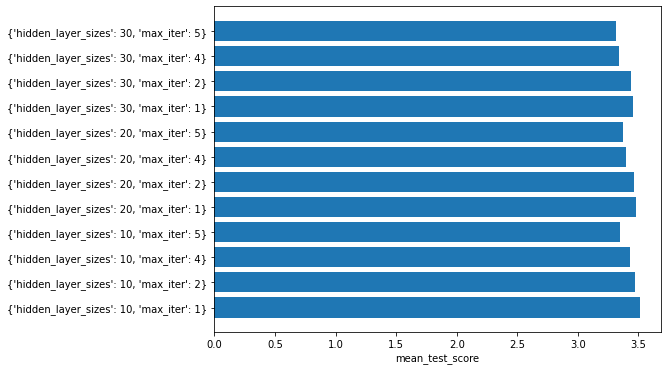

In [38]:
plt.figure(figsize=(8, 6))
plt.barh(range(12), -clf.cv_results_['mean_test_score'])
_ = plt.yticks(range(12), clf.cv_results_['params'])
plt.xlabel('mean_test_score')

In [39]:
model = MLPRegressor(hidden_layer_sizes=30,learning_rate_init=0.01,max_iter=5,early_stopping=True,verbose=True)
model.fit(X_train,Y_train)
pred_mlp = model.predict(X_test)
mse = np.sqrt(mean_squared_error(pred_mlp, Y_test))
print(mse)

Iteration 1, loss = 6.33894814
Validation score: 0.935079
Iteration 2, loss = 5.52233118
Validation score: 0.938267
Iteration 3, loss = 5.46772605
Validation score: 0.938468
Iteration 4, loss = 5.44558315
Validation score: 0.937337
Iteration 5, loss = 5.43149050
Validation score: 0.937375


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


3.2570964199895482


In [40]:
filename='MLP_model.sav'
pickle.dump(model,open(filename,'wb'))

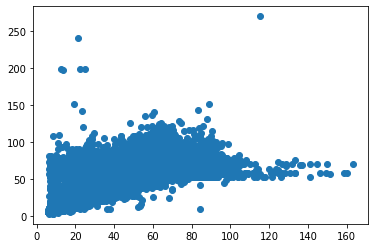

In [41]:
plt.scatter(pred_lr, Y_test)

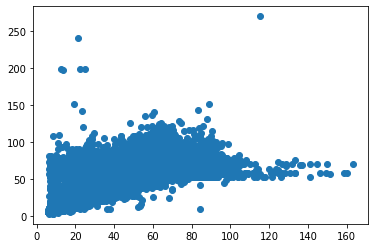

In [42]:
plt.scatter(pred_ridge, Y_test)

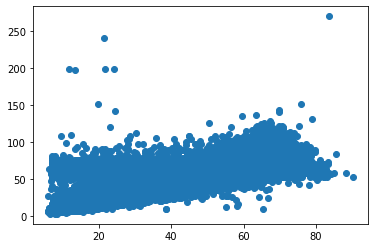

In [43]:
plt.scatter(pred_mlp, Y_test)

In [57]:
best_mse = 1.0
for x1 in np.linspace(0.05, 0.95, 19):
    for x2 in np.linspace(0.05, 0.95, 19):
        if x1 + x2 >= 1:
            continue
        
        x3 = 1 - x1 - x2
        
        mse = np.sqrt(mean_squared_error((pred_lr*x1+pred_ridge*x2+pred_mlp*x3), Y_test))
        if mse < best_mse:
            print(x1, x2, x3, mse)
            best_mse = mse

In [45]:
mse = np.sqrt(mean_squared_error((pred_lr*0.05+pred_ridge*0.05+pred_mlp*0.9), Y_test))
print(mse)

3.2598739755368173


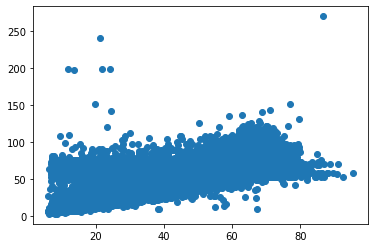

In [46]:
plt.scatter((pred_lr*0.05+pred_ridge*0.05+pred_mlp*0.9), Y_test)

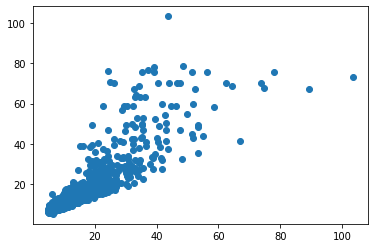

In [47]:
plt.scatter(df['duration'].iloc[:1000], df['total_amount'].iloc[:1000])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


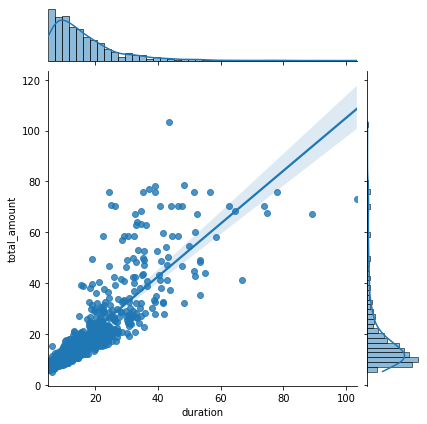

In [48]:
sns.jointplot(df['duration'].iloc[:1000], df['total_amount'].iloc[:1000], kind="reg")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


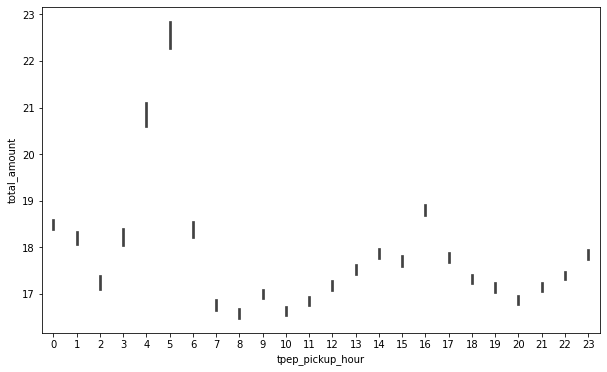

In [49]:
plt.figure(figsize=(10, 6))
sns.barplot(df['tpep_pickup_hour'].iloc[:], df['total_amount'].iloc[:])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


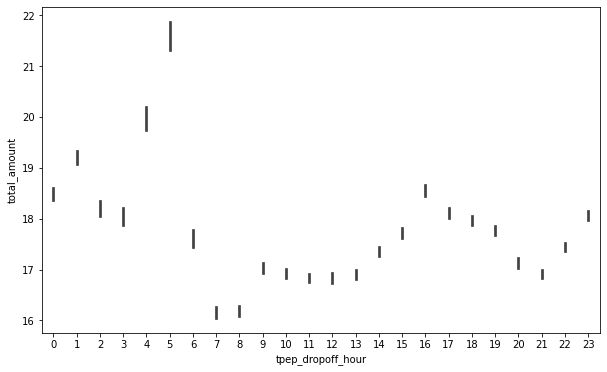

In [50]:
plt.figure(figsize=(10, 6))
sns.barplot(df['tpep_dropoff_hour'].iloc[:], df['total_amount'].iloc[:])

Model evaluation to ensure satisfactory performance

In [53]:
def test_lr_running_time(X_train,Y_train,X_test,Y_test):
    time_start = time.time()
    model = LinearRegression(fit_intercept=True, normalize=True)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    time_end = time.time() 
    time_c= time_end - time_start
    assert time_c<1.0, 'model running time should be less than 1 sec'
    print("Linear regression model running time test success!")

def test_ridge_running_time(X_train,Y_train,X_test,Y_test):
    time_start = time.time()
    model = Ridge(alpha=0.2,fit_intercept=True,max_iter=500,normalize=False)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    time_end = time.time() 
    time_c= time_end - time_start
    assert time_c<1.0, 'model running time should be less than 1 sec'
    print("Ridge regression model running time test success!")

def test_MLP_running_time(X_train,Y_train,X_test,Y_test):
    time_start = time.time()
    model = MLPRegressor(hidden_layer_sizes=30,learning_rate_init=0.01,max_iter=5,early_stopping=True,verbose=True)
    model.fit(X_train,Y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    time_end = time.time() 
    time_c= time_end - time_start
    assert time_c<600.0, 'model running time should be less than 1 sec'
    print("Multilayer Perceptron model running time test success!")

In [54]:
test_lr_running_time(X_train,Y_train,X_test,Y_test)
print("----------------------------------------------------------------------------")
test_ridge_running_time(X_train,Y_train,X_test,Y_test)
print("----------------------------------------------------------------------------")
test_MLP_running_time(X_train,Y_train,X_test,Y_test)

Linear regression model running time test success!
----------------------------------------------------------------------------
Ridge regression model running time test success!
----------------------------------------------------------------------------
Iteration 1, loss = 6.26595676
Validation score: 0.938445
Iteration 2, loss = 5.53063957
Validation score: 0.939395
Iteration 3, loss = 5.48325907
Validation score: 0.939713
Iteration 4, loss = 5.45541211
Validation score: 0.937279
Iteration 5, loss = 5.45352778
Validation score: 0.931018


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Multilayer Perceptron model running time test success!
